Welcome to the EEA Summer School 2025!

Let's do some exercises.

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
import cvxpy as cp

In [22]:
m = 50
n = 100
A = np.random.rand(m, n) + 1j * np.random.randn(m, n)
x_true = np.zeros(n, dtype=complex)
x_true[0] = 1 + 2j
y = A @ x_true + (np.random.randn(m) + 1j * np.random.randn(m)) * 0.1

In [23]:
x = cp.Variable(n, complex=True)
cost = cp.sum_squares(A @ x - y) + cp.norm(x, 1)
prob = cp.Problem(cp.Minimize(cost))
prob.solve()

np.float64(2.7232472002268966)

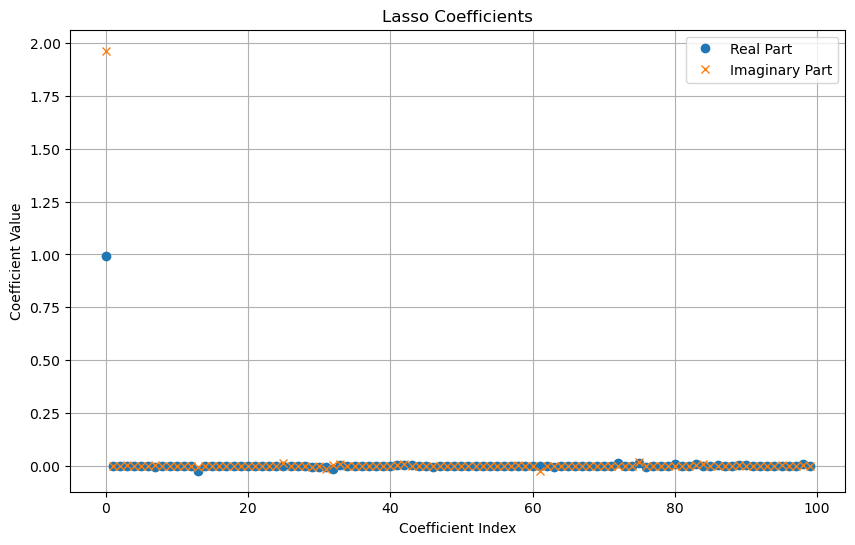

In [24]:

plt.figure(figsize=(10, 6))
plt.plot(x.value.real, marker='o', linestyle='None')
plt.plot(x.value.imag, marker='x', linestyle='None')
plt.legend(['Real Part', 'Imaginary Part'])
plt.title('Lasso Coefficients')
plt.xlabel('Coefficient Index')
plt.ylabel('Coefficient Value')
plt.grid()
plt.show()